# Analysing images from various sources
In this notebook I will be looking into various sources of Christian Art and establish whether the descriptions in these sources are good enough to explain the art.

## Ingredients
Some required imports and installations

In [ ]:
!pip install bs4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install deep-translator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 128 kB 7.8 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import cv2
from PIL import Image
import pandas as pd

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224))
])

In [ ]:
from bs4 import BeautifulSoup
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import matplotlib.pyplot as plt
import requests
import plotly.express as px

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
STOP_WORDS = stopwords.words()
wnl = WordNetLemmatizer()

## 1. Art Institute of Chicago
The Art Institute of Chicago has a rich source of 50,000 images which are provided under CC0 license. Let's look into some of the images from the collection

We are using beautifulsoup to scrape images of the site.

### Prepping the images and descriptions scraped

In [ ]:
response = requests.get("https://www.artic.edu/collection?q=saint")
soup = BeautifulSoup(response.text)
links = []
descriptions = []
timelines = []

In [ ]:
for year in soup.findAll('strong'):
  try:
    res = year.text.strip(string.ascii_letters)
    res = re.findall('[0-9]+', year.text)
    if(res == []):
      timelines.append(0)
    else:
      timelines.append(int(res[0]))
  except Exception as e:
    timelines.append(-1)
    

### Alright
I have compiled the images from the first page of Art Institute of Chicago. Time to move forward...

In [ ]:
for img in soup.findAll('img'):
    link = img.get('data-pin-media')
    if(link is not None):
      links.append(link)
      descriptions.append(img.get('alt'))

In [ ]:
arts_src_chicago_df = pd.DataFrame({"links": links, "descriptions": descriptions, "timelines": timelines})

In [ ]:
arts_src_chicago_df.head()

,links,descriptions,timelines
0,https://www.artic.edu/iiif/2/631c7df4-4ad1-db4...,Silver-toned reliquary in the shape of a long ...,1100
1,https://www.artic.edu/iiif/2/1f5b595f-dbbd-3c9...,"Large painting of woman, in gold and pink dres...",1639
2,https://www.artic.edu/iiif/2/7c752046-744f-2f6...,"Large painting of Holy Family: Mary in red, ho...",1615
3,https://www.artic.edu/iiif/2/b82fd3da-48ef-ca2...,Light wood sculpture of angel with shield look...,1475
4,https://www.artic.edu/iiif/2/a80e815d-aebd-a6c...,"Half circle of fabric, embroidered with Virgin...",1490


### Preprocessing
In order to analyze the source better, we will preprocess the text and perform feature engineering to add some new columns

In [ ]:
import re
import string
def preprocess_text(text):


        text = re.sub(r'\d+', "", text)

        # Removing hyperlinks
        text = re.sub('http://\S+|https://\S+', '', text)

        # Removing emojis
        emoji_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F"
                            u"\U0001F680-\U0001F6FF"
                            u"\U0001F1E0-\U0001F1FF"
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            "]+", flags=re.UNICODE)
        text = emoji_pattern.sub(r'', text)

        # Removing some common symbols
        text = re.sub(r'@\w+',  '', text).strip()
        text = re.sub("[^a-zA-Z0-9 ']", "", text)

        # Using a lemmatizer to get a final text
        text=' '.join([wnl.lemmatize(i) for i in text.lower().split()])

        # Tokenize the text
        text_tokens = word_tokenize(text)

        # Itertating through the word and if a word is not in the stop words then adding it to the list
        tokens_without_sw = [word for word in text_tokens if not word in STOP_WORDS]

        # Getting the filtered sentence
        filtered_sentence = (" ").join(tokens_without_sw)
        text = filtered_sentence

        # Returning the transformed/filtered text
        return text

### Adding the length of descriptions as a column.
This might help in interpreting the length of the captions from the source

In [ ]:
arts_src_chicago_df['desc_length'] = arts_src_chicago_df['descriptions'].apply(len)

In [ ]:
arts_src_chicago_df['desc_length'].max()

314

In [ ]:
arts_src_chicago_df['desc_length'].min()

13

In [ ]:
arts_src_chicago_df['desc_preprocessed'] = arts_src_chicago_df['descriptions'].apply(preprocess_text)
arts_src_chicago_df['desc_length_ranges']= pd.cut(arts_src_chicago_df.desc_length, [0,50, 100, 150, 200, 250, 300, 350], labels = ["0-50", "51-100", "101-150", "151-200", "201-250", "251-300", "301-350"], include_lowest=True)

In [ ]:
arts_src_chicago_df.timelines.max()

1936

In [ ]:
arts_src_chicago_df.timelines.min()

0

### Splitting the timeline into timeline ranges
This will help in determine the period the painting belonged to. Whether it has more paintings from renaissance era or from some other era

In [ ]:
arts_src_chicago_df['timeline_ranges']= pd.cut(arts_src_chicago_df.timelines, [0,100, 400, 800, 1200, 1600, 2000], labels = ["No timeline","101-400","401-800", "801-1200", "1201-1600", "1601-2000"], include_lowest=True)

### Interpreting the length of the descriptions.

In [ ]:
fig = px.histogram(arts_src_chicago_df, x="desc_length_ranges", title = "Lengths of the art descriptions", color = "desc_length_ranges")
fig.show()

Of the 55 images we scraped we see that most of them lie in the range 0-50 followed by the range 51-100. Interesting enough we see captions also of the sizes 251-300, 101-150 which would possibly instill the confidence that these descriptions are descriptive enough

### Interpreting the timeline of the paintings

In [ ]:
fig = px.histogram(C, x="timeline_ranges", title = "Creation time of the paintings", color = "timeline_ranges")
fig.show()

We see that most of the paintings are from 1601-2000 timeline followed closely by the renaissance era. 

Note: The 'No timeline' bar means that the descriptions didn't have any information regarding the time they were painted.

### Interpreting the images

In [ ]:
images = []
for link in arts_src_chicago_df['links']:
  if(link is not None):
    image = Image.open(requests.get(link, stream=True).raw)
    images.append(transform(image))


In [ ]:
images = torch.stack(images)

In [ ]:
images.shape

torch.Size([55, 3, 224, 224])

In [ ]:
plt.rcParams["figure.figsize"] = (15,1)

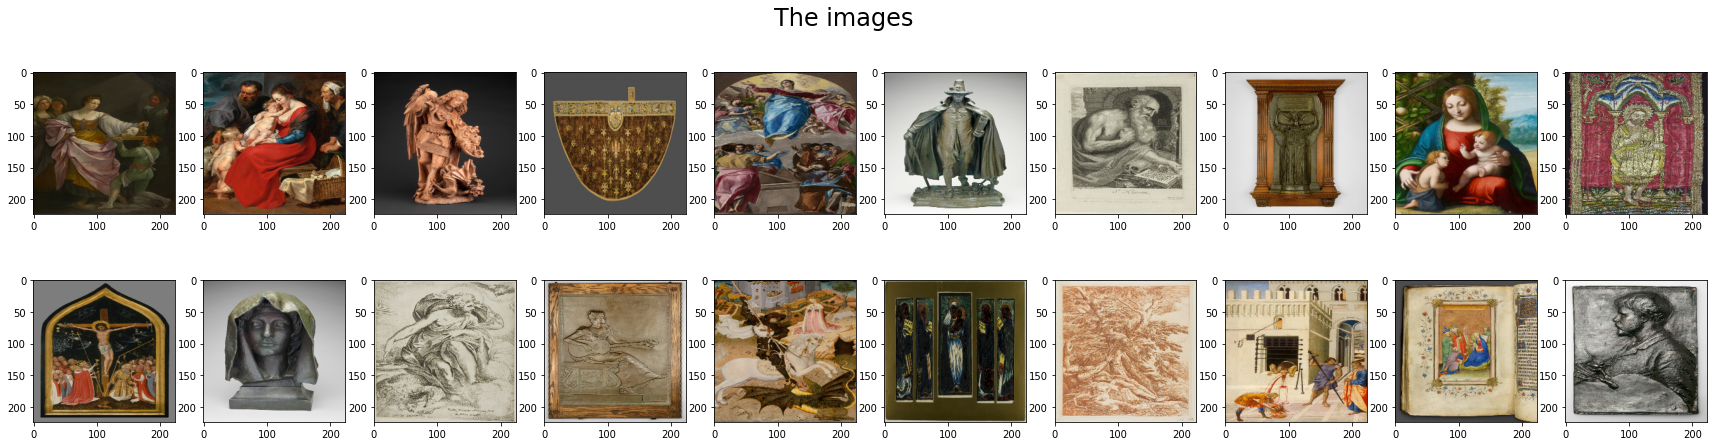

In [ ]:
idx = 1
fig, axes = plt.subplots(2, 10, figsize=(30,7))
fig.suptitle("The images", fontsize = 24)
for i in range(2):
    for j in range(10):
        image = images[idx]
        image = image.cpu().detach().squeeze(0).permute(1,2,0).numpy()
        axes[i,j].imshow(image)
        idx+=1
        
plt.show()

### Painting 1
![p1](https://user-images.githubusercontent.com/53506835/174435659-888f279c-5f3b-47b4-a9e8-4742e5633f17.png)


### Description
Large painting of woman, in gold and pink dress, placing severed head on platter.

### My outlook
What I understand from this painting is that a woman is indeed placing severed head on a platter but on a normal basis no one does that and hence I think there is a deeper meaning to this but the description merely explains the objects in image.

### Painting 2
![p2](https://user-images.githubusercontent.com/53506835/174436381-9391073e-a41b-4dcf-b285-b37a17ddd800.png)

### Description
Large painting of Holy Family: Mary in red, holding baby Jesus.

### My outlook
Now if I would see this image. I would deduct that there is a mother caressing two babies along with some family members. The description I think gives me a better intuition as to who these people really are. Hence it seems more meaningful than what normal people such as me would think upon looking at this image.

### Painting 3
![p3](https://user-images.githubusercontent.com/53506835/174436614-24e9aa16-c2f1-4c2c-9af0-5c68d037068b.png)

### Description
Painting of the Virgin Mary ascending to heaven amongst multitude of angels.

### My outlook
I would say there are a group of people that are doing something together and maybe they are flying so they have wings. Apart from that I don't know the actor in the painting or the background actors. The description seems good as it makes me understand that the flying people are angels, the actor is Mary and the place they are flying off to is heaven.

### Painting 4
![p4](https://user-images.githubusercontent.com/53506835/174436827-d51f9281-836a-4bc2-9cca-deb597b7a8f5.png)

## Description
Engraving of a old man with a long beard, wearing only a cloth draped around one shoulder, bending over a table with books, a quill pen and ink, a skull, and glasses. The man looks at a small crucifix with a figure of Jesus.

## My outlook
What I understand from this is that there is an old person who looks like a sage or saint and is trying to read/write something.


### Painting 5
![p5](https://user-images.githubusercontent.com/53506835/174436979-37849adf-035e-4591-98a6-f3767e8fdd75.png)

## Description
Vividly colored painting of Virgin Mary with baby Jesus and baby John the Baptist.

## My outlook
The last painting of Saint Mary also had similar red-colored clothing so my assumption is that she is Mary and she is holding two children and one of them might be Lord Jesus.

## 2. Cleveland Museum of Art
The Cleveland Museum provides access to over 60k images.  

In [ ]:
!wget https://github.com/ClevelandMuseumArt/openaccess/blob/master/data.json?raw=true

--2022-06-20 08:00:59--  https://github.com/ClevelandMuseumArt/openaccess/blob/master/data.json?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/ClevelandMuseumArt/openaccess/raw/master/data.json [following]
--2022-06-20 08:00:59--  https://github.com/ClevelandMuseumArt/openaccess/raw/master/data.json
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/ClevelandMuseumArt/openaccess/master/data.json [following]
--2022-06-20 08:00:59--  https://media.githubusercontent.com/media/ClevelandMuseumArt/openaccess/master/data.json
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.110.133|:4

In [ ]:
!mv /content/data.json?raw=true /content/data.json

In [ ]:
arts_src_cleve_df = pd.read_json('/content/data.json')

### Filtering the dataset
- The current source also has images from neolithic era and we are not focussing on those and hence those images are removed.

- While the Cleveland Museum has a rich source of 60k images. Not all of them contain detailed descriptions. Hence, the current exploration is only limited to the images that have these descriptions.


In [ ]:
arts_src_cleve_df = arts_src_cleve_df[arts_src_cleve_df.creation_date_earliest>=0]
arts_src_cleve_df = arts_src_cleve_df[arts_src_cleve_df.digital_description.isnull() == False]

In [ ]:
arts_src_cleve_df.head()

,id,accession_number,share_license_status,tombstone,current_location,title,title_in_original_language,series,series_in_original_language,creation_date,...,digital_description,wall_description,external_resources,citations,catalogue_raisonne,url,images,updated_at,sketchfab_id,sketchfab_url
0,74539,2015.449,CC0,"A Miller's Carriage, c. 1895. Albert-Charles L...",None,A Miller's Carriage,None,None,None,c. 1895,...,Albert Rouen was known for his work in charcoa...,None,"{'wikidata': [], 'internet_archive': ['https:/...",[],None,https://clevelandart.org/art/2015.449,{'web': {'url': 'https://openaccess-cdn.clevel...,2022-03-19 09:00:05.141,NaN,NaN
3,74570,2018.41,CC0,"Profile Portrait of a Man, 18th century. Attri...",None,Profile Portrait of a Man,None,None,None,18th century,...,This portrait bust is a counterproof: the reve...,None,"{'wikidata': [], 'internet_archive': ['https:/...",[],None,https://clevelandart.org/art/2018.41,{'web': {'url': 'https://openaccess-cdn.clevel...,2022-01-04 14:31:21.665,NaN,NaN
4,74572,2018.42,CC0,"The Temptation of St. Anthony, 19th century. J...",None,The Temptation of St. Anthony,None,None,None,19th century,...,Boilly’s scene represents the Temptations of S...,None,"{'wikidata': [], 'internet_archive': []}",[],None,https://clevelandart.org/art/2018.42,{'web': {'url': 'https://openaccess-cdn.clevel...,2022-01-04 14:31:22.016,NaN,NaN
6,74580,2018.43,CC0,"Costume Study, before 1852. Henri Lehmann (Fre...",None,Costume Study,None,None,None,before 1852,...,Lehmann’s drawing belongs to a pair in which t...,None,"{'wikidata': [], 'internet_archive': []}","[{'citation': 'Lehmann, Henri, and Marie-Madel...",None,https://clevelandart.org/art/2018.43,{'web': {'url': 'https://openaccess-cdn.clevel...,2022-01-04 14:31:22.591,NaN,NaN
7,74581,2018.44,CC0,"Nude Study of an Old Man, before 1852. Henri L...",None,Nude Study of an Old Man,None,None,None,before 1852,...,In preparation for executing largescale painti...,None,"{'wikidata': [], 'internet_archive': []}","[{'citation': 'Lehmann, Henri, and Marie-Madel...",None,https://clevelandart.org/art/2018.44,{'web': {'url': 'https://openaccess-cdn.clevel...,2022-01-04 14:31:22.774,NaN,NaN


### Adding newer columns.
In order to analyze the source, we add some new columns for the title, description and creation time (of the painting).

In [ ]:
arts_src_cleve_df['title_len'] = arts_src_cleve_df['title'].apply(len)

In [ ]:
arts_src_cleve_df['title_len'].max()

584

In [ ]:
arts_src_cleve_df['title_len'].min()

3

In [ ]:
arts_src_cleve_df['title_length_ranges'] = pd.cut(
    arts_src_cleve_df.title_len, 
    [0,100, 200, 300, 400, 500, 600],
    labels = ["0-100", "101-200", "201-300", "301-400", "401-500", "501-600"],
    include_lowest=True
)

In [ ]:
arts_src_cleve_df['digital_description'] = arts_src_cleve_df['digital_description'].fillna("Not available")
arts_src_cleve_df['desc_length'] = arts_src_cleve_df['digital_description'].apply(len)

In [ ]:
arts_src_cleve_df['creation_date_earliest'] = arts_src_cleve_df['creation_date_earliest'].fillna(0)

In [ ]:
arts_src_cleve_df['desc_length'].min()

17

In [ ]:
arts_src_cleve_df['desc_length'].max()

4082

In [ ]:
arts_src_cleve_df['desc_length_ranges'] = pd.cut(
    arts_src_cleve_df.desc_length, 
    [0,25, 50, 100, 500, 1000, 2000, 3500, 4100],
    labels = ["0-25", "26-50", "51-100", "101-500", "501-1000", "1001-2000", "2001-3500", "3501-4100"],
    include_lowest=True
)

In [ ]:
arts_src_cleve_df.creation_date_earliest.min()

1.0

In [ ]:
arts_src_cleve_df.creation_date_earliest.max()

2021.0

In [ ]:
arts_src_cleve_df['timeline_ranges']= pd.cut(arts_src_cleve_df.creation_date_earliest, [0,100, 400, 800, 1200, 1600, 2022], labels = ["No timeline","101-400","401-800", "801-1200", "1201-1600", "1601-2000"], include_lowest=True)

### Interpereting the titles

In [ ]:
fig = px.histogram(x=arts_src_cleve_df["title_length_ranges"], title = "Lengths of the titles", color = arts_src_cleve_df["title_length_ranges"])
fig.show()

A title is an exact description of what might be happening in an image. It doesn't really give us an idea about the hidden patterns that are latent in the painting.

For the current dataset, we see that most titles are mostly in the range 0-100 which is normal since titles are supposed to be shorter

### Interpreting the descriptions

In [ ]:
fig = px.histogram(x=arts_src_cleve_df["desc_length_ranges"], title = "Lengths of the art descriptions", color = arts_src_cleve_df["desc_length_ranges"])
fig.show()

On the contrary, descriptions seem to be longer which seems like a good sign as that would be better to understand the painting.


### Interpreting the time of creation

In [ ]:
fig = px.histogram(x=arts_src_cleve_df["timeline_ranges"], title = "Creation times", color = arts_src_cleve_df["timeline_ranges"])
fig.show()

### Interpreting via images

In [ ]:
idx = 0
images = []
descriptions = []
for i in range(len(arts_src_cleve_df)):
  link =arts_src_cleve_df.iloc[i]['images']
  description = arts_src_cleve_df.iloc[i]['digital_description']
  if(link is not None):
    if(idx>50):
      break
    idx+=1
    ilink = link['web']['url']

    image = Image.open(requests.get(ilink, stream=True).raw)
    images.append(transform(image))
    descriptions.append(description)


### Painting 1
![p6](https://user-images.githubusercontent.com/53506835/174560904-69f66fe3-e67c-4d14-a7f2-455bb99ae5c1.png)

### My outlook
The top corner of the painting depicts Lord Jesus and it maybe feels like some people were mourning.

### Description

According to Christian belief, three days after his death by crucifixion, Christ rose from the dead and ascended into heaven. König’s interpretation of this traditional theme employs vivid colors and explosive poses to express the drama of the event. Meticulous brushwork delineates exquisite details, and draws attention to the luminous landscape and the three holy women hastening towards Christ’s vacant tomb.

### Title
The Resurrection of Christ


### Painting 2

![p7](https://user-images.githubusercontent.com/53506835/174561418-7ea380d0-fdba-4230-8041-56b018ba9284.png)

### My outlook
It feels like a mother is holding her baby. The baby could be Jesus but I am not sure.

### Description
This small devotional object differs stylistically from Buglioni's Madonna and Child Enthroned with Saints Francis and Anthony Abbot (1921.1180), also in the museum's collection.  In contrast to the other work, the faces of the Madonna and Child are significantly less expressive, and the passages of exposed skin have been left unglazed.  The Madonna holds a nude Christ on her left arm and wears a mantle of blue with green lining and a maroon tunic with a yellow collar and cuffs.  Her bright yellow shoes and the purple of her tunic are characteristic of Buglioni's color scheme and can also be seen in the other work.  The tabernacle frame is probably contemporary to the figures, although it may not have been created specifically for this altarpiece.  Buglioni likely worked in the studio of Andrea della Robbia, where he would have studied the family's techniques for glazing terracotta.  The frame is classically inspired, with Corinthian capitals and Buglioni's characteristic egg and dart 

### Title
Virgin and Child


## 3. Ontologie du christianisme médiéval en images
A visual encyclopedia of Christian thought in the medieval West.

### Translation.
The captions are in French so we are translating it using deep_translator

In [ ]:
from deep_translator import GoogleTranslator

In [ ]:
translator = GoogleTranslator(source='auto', target='en')

In [ ]:
url = "https://omci.inha.fr/s/ocmi/page/images"
response = requests.get(url)
soup = BeautifulSoup(response.text)
links = []
descriptions = []
titles = []

### Prepping images and the descriptions

In [ ]:
for img in soup.findAll('img'):
    if(link is not None):
      titles.append(translator.translate(img.get('alt')))
      links.append(img.get('src'))

In [ ]:
for desc in soup.findAll('a'):
  description = desc.get('data-description')
  if(description is not None):
    description = description.split("<")[0]
    descriptions.append(translator.translate(description))

In [ ]:
arts_src_omci_df = pd.DataFrame({"links": links[1:], "descriptions": descriptions, "title": titles[1:]})

### Result
After scraping the site this is what we get

In [ ]:
arts_src_omci_df

,links,descriptions,title
0,https://omci.inha.fr/files/square/399/Christ_c...,This crucifix is ​​part of a vast production o...,Christ on the cross
1,https://omci.inha.fr/files/square/bbc602719795...,The Book of Hours of Marie de Bourgogne is a w...,Madonna and Child
2,https://omci.inha.fr/files/square/241/St_Alban...,This drop cap opens verses 105 to 112 of Psalm...,Man Lifting His Soul to God
3,https://omci.inha.fr/files/square/421/1_God_an...,The so-called Psalter of Queen Mary is a manus...,Christ reigning over the universe
4,https://omci.inha.fr/files/square/207/Arma_Chr...,This devotional booklet consists of six sheets...,Arms of Christ
...,...,...,...
108,https://omci.inha.fr/files/square/292/Enfer_Co...,The tympanum of the western portal of the Sain...,Hell
109,https://omci.inha.fr/files/square/184/christ_r...,"The statue represents the blessing Christ, dre...",Christ of the Palms
110,https://omci.inha.fr/files/square/263/Stuttgar...,This psalter was made during the first third o...,crippled
111,https://omci.inha.fr/files/square/331/Benedic_...,The Benedictionary of Æthelwold is a manuscrip...,Annunciation to the Virgin


### Adding more columns.
So that we can analyze the descriptions and titles of the paintings

In [ ]:
arts_src_omci_df['title_len'] = arts_src_omci_df['title'].apply(len)

In [ ]:
arts_src_omci_df['title_len'].min()

4

In [ ]:
arts_src_omci_df['title_len'].max()

72

In [ ]:
arts_src_omci_df['title_length_ranges'] = pd.cut(
    arts_src_omci_df.title_len, 
    [0, 15, 30, 45, 60, 75],
    labels = ["0-15", "16-30", "31-45", "46-60", "61-75"],
    include_lowest=True
)

In [ ]:
arts_src_omci_df['desc_length'] = arts_src_omci_df['descriptions'].apply(len)

In [ ]:
arts_src_omci_df['desc_length'].min()

0

In [ ]:
arts_src_omci_df['desc_length'].max()

1027

In [ ]:
arts_src_omci_df['desc_length_ranges']= pd.cut(arts_src_omci_df.desc_length, [0, 200, 400, 600, 800, 1000, 1100], labels = ["0-200", "201-400", "401-600", "601-800", "801-1000", "1001-1100"], include_lowest=True)

### Interpreting the lengths of titles

In [ ]:
fig = px.histogram(x=arts_src_omci_df["title_length_ranges"], title = "Lengths of the titles", color = arts_src_omci_df["title_length_ranges"])
fig.show()

Most of the titles are in the range 16-30 which seems normal enough as titles are shorter.

### Interpreting the descriptions

In [ ]:
import plotly.express as px
fig = px.histogram(arts_src_omci_df, x="desc_length_ranges", title = "Lengths of the art descriptions", color = "desc_length_ranges")
fig.show()

The descriptions are longer than the titles which would possibly mean that they hold more information about the artpiece.

### Painting 1

![p8](https://user-images.githubusercontent.com/53506835/174567954-9e41449c-80dc-4c86-87ec-8a4f8b34fcba.png)

### My outlook
A center figure seems to be in control of other people. The other people seem like they are worshipping him

### Description
Charles the Bald's First Bible was produced around 845 and features an exceptional set of full-page miniatures. On this sheet, Christ occupies the central place and around him unfolds a rigorously ordered geometric composition. He is seated on a globe, holding the scriptures in his left hand and a small globe in his right hand.

### Title
Majesty of the Lord


### Painting 2
![p9](https://user-images.githubusercontent.com/53506835/174568308-0be9b073-9591-4d7c-8f18-a979f38188a4.png)

### My outlook
In a similar fashion, I think Christ is the central figure in this picture and there are other people who might be worshipping him

### Description
Saint Peter and Saint Paul receive the Law of Christ enthroned in the center in the mandorla. Behind the princes of the apostles, other saints are distributed on either side of the Majestas Domini.

### Title
Christ handing over the law to Saint Paul and the keys to Saint Peter

